# Tutorial 3

In [43]:
import sympy as s 
from sympy.abc import x
import math 
import numpy as np
import matplotlib.pyplot as plt 
import plot_utils as pu # Make sure that your path is in the same folder! 
import importlib
import time
importlib.reload(pu)

from sympy.physics.vector import dynamicsymbols, init_vprinting # our symbols will be dynamic ones :) 
init_vprinting() # start newton notation

%matplotlib widget

## Jacobians
1. Bring back your 3DOF model from T1. But this time reduce it to only 1DOF (elbow flexion and extension)

In [44]:
cos = lambda deg : np.cos(np.radians(deg))
sin = lambda deg : np.sin(np.radians(deg))

rot_x = lambda a: np.array([[ 1, 0, 0], 
                 [ 0, cos(a), -sin(a)],
                 [ 0, sin(a), cos(a)]]) 
rot_y = lambda b: np.array([[ cos(b), 0, sin(b)], 
                [ 0, 1, 0],
                [ -sin(b), 0, cos(b)]]) 
rot_z = lambda c: np.array([[ cos(c), -sin(c), 0], 
                [ sin(c), cos(c), 0],
                [ 0, 0, 0]])

In [45]:
L1_ = 0.4 #Distance from your shoulder to your elbow [m]
L2_ = 0.3 #Distance from your elbow to your wrist [m]
L3_ = 0.1 #Distance from your wrist to the middle of your palm [m]

q0__ = -90.0
q1__= 45.0
q2__= 0.0
q3__= 0.0
H_temp = np.array([[0.0, 0.0, 0.0, 0.0],
                 [0.0, 0.0, 0.0, 0.0],
                 [0.0, 0.0, 0.0, 0.0],
                 [0.0, 0.0, 0.0, 1.0]])

#------------- From world frame to joint 0----------------------
H0_w = H_temp.copy()
tvec_0_w = np.array([[0.0], 
                    [0.0], 
                    [L1_+L2_+L3_]])

rot_0_w = rot_x(90)@rot_z(q0__)
H0_w[:3,:] = np.append(rot_0_w, tvec_0_w, axis=1)[:,:]

pi = s.pi
q1= dynamicsymbols('q1', real=True)
t = s.Symbol('t')
L1,L2,L3= s.symbols('L1 L2 L3', real=True)
# DH Table [theta|d|a|alpha] 
D = s.Matrix([[0, 0, L1, 0], \
              [q1, 0, L2, 0], \
              [0, 0, L3, 0]])

In [46]:

def calcTransformation(D):
    H = []
    for i in range(0,D.shape[0]):
        Hrel = s.Matrix([
            [s.cos(D[i,0]), -1*s.sin(D[i,0])*s.cos(D[i,3]), s.sin(D[i,0])*s.sin(D[i,3]), D[i,2]*s.cos(D[i,0])],\
            [s.sin(D[i,0]), s.cos(D[i,0])*s.cos(D[i,3]) , -1*s.cos(D[i,0])*s.sin(D[i,3]), D[i,2]*s.sin(D[i,0])],\
            [0, s.sin(D[i,3]) , s.cos(D[i,3]), D[i,1]],\
            [0,0,0,1]])
        Hrel=s.simplify(Hrel)
        H.append(Hrel)
    return H

#relH[0] = H1_0
#relH[1] = H2_1
#relH[2] = H3_2
relH = calcTransformation(D)
def calcTransformationAbs(H):
    absH = []
    for i in range (0,len(H)):
        # append first abs transformation to list
        if(i==0):
            H[i] = s.simplify(H[i])
            absH.append(H[i])
        else:
            #matmul previous absH with current H 
            absH_tmp = absH[i-1]*H[i]
            absH_tmp=s.simplify(absH_tmp)
            absH.append(absH_tmp)
    return absH

#absH[0] = H1_0
#absH[1] = H2_0
#absH[2] = H3_0
absH = calcTransformationAbs(relH)
# absH
def calcTransformationWorld(H0_w,H):
    wH = []
    for i in range(0,len(H)):
        wH_temp = H0_w*H[i]
        wH_temp = s.simplify(wH_temp)
        wH.append(wH_temp)
    return wH

#wH[0] = H1_w
#wH[1] = H2_w
#wH[2] = H3_w
wH = calcTransformationWorld(H0_w, absH)

In [47]:
relH

⎡⎡1  0  0  L₁⎤  ⎡cos(q₁)  -sin(q₁)  0  L₂⋅cos(q₁)⎤  ⎡1  0  0  L₃⎤⎤
⎢⎢           ⎥  ⎢                                ⎥  ⎢           ⎥⎥
⎢⎢0  1  0  0 ⎥  ⎢sin(q₁)  cos(q₁)   0  L₂⋅sin(q₁)⎥  ⎢0  1  0  0 ⎥⎥
⎢⎢           ⎥, ⎢                                ⎥, ⎢           ⎥⎥
⎢⎢0  0  1  0 ⎥  ⎢   0        0      1      0     ⎥  ⎢0  0  1  0 ⎥⎥
⎢⎢           ⎥  ⎢                                ⎥  ⎢           ⎥⎥
⎣⎣0  0  0  1 ⎦  ⎣   0        0      0      1     ⎦  ⎣0  0  0  1 ⎦⎦

In [48]:
absH

⎡⎡1  0  0  L₁⎤  ⎡cos(q₁)  -sin(q₁)  0  L₁ + L₂⋅cos(q₁)⎤  ⎡cos(q₁)  -sin(q₁)  0
⎢⎢           ⎥  ⎢                                     ⎥  ⎢                    
⎢⎢0  1  0  0 ⎥  ⎢sin(q₁)  cos(q₁)   0    L₂⋅sin(q₁)   ⎥  ⎢sin(q₁)  cos(q₁)   0
⎢⎢           ⎥, ⎢                                     ⎥, ⎢                    
⎢⎢0  0  1  0 ⎥  ⎢   0        0      1         0       ⎥  ⎢   0        0      1
⎢⎢           ⎥  ⎢                                     ⎥  ⎢                    
⎣⎣0  0  0  1 ⎦  ⎣   0        0      0         1       ⎦  ⎣   0        0      0

  L₁ + L₂⋅cos(q₁) + L₃⋅cos(q₁)⎤⎤
                              ⎥⎥
       (L₂ + L₃)⋅sin(q₁)      ⎥⎥
                              ⎥⎥
               0              ⎥⎥
                              ⎥⎥
               1              ⎦⎦

In [49]:
wH

⎡⎡6.12323399573677e-17           1.0           0  6.12323399573677e-17⋅L₁ ⎤  ⎡
⎢⎢                                                                        ⎥  ⎢
⎢⎢-6.12323399573677e-17  3.74939945665464e-33  0  -6.12323399573677e-17⋅L₁⎥  ⎢
⎢⎢                                                                        ⎥, ⎢
⎢⎢        -1.0           6.12323399573677e-17  0          0.8 - L₁        ⎥  ⎢
⎢⎢                                                                        ⎥  ⎢
⎣⎣          0                     0            0            1.0           ⎦  ⎣

        1.0⋅sin(q₁) + 6.12323399573677e-17⋅cos(q₁)                   -6.123233
                                                                              
3.74939945665464e-33⋅sin(q₁) - 6.12323399573677e-17⋅cos(q₁)  6.12323399573677e
                                                                              
          6.12323399573677e-17⋅sin(q₁) - cos(q₁)                     1.0⋅sin(q
                                                   

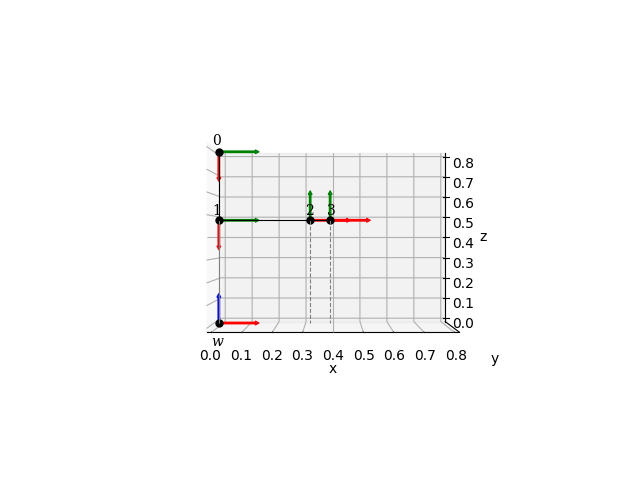

In [50]:
# change the angles 
# change the angles 
H_list=[]
H = s.lambdify((x),s.Matrix(H0_w),modules="numpy")
H_list.append(H(0))
for wH_ in wH:
    H = s.lambdify((q1,L1,L2,L3,pi),wH_,modules="numpy")
    L1_ = 0.32
    L2_ = 0.32
    L3_ = 0.07
    q1_ = np.radians(90)
    H_list.append(H(q1_,L1_,L2_,L3_,np.pi))    

pu.plotTrans(H_list)

In [51]:
H0_w

array([[ 6.12323400e-17,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-6.12323400e-17,  3.74939946e-33,  0.00000000e+00,
         0.00000000e+00],
       [-1.00000000e+00,  6.12323400e-17,  0.00000000e+00,
         8.00000000e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

2. Calculate your DH table and homogeneous transformation to the center of mass. Assume the center of mass of the fore and upper arm are in the middle, and the center of mass of the hand is in the middle of the palm (same position as the end effector)

In [52]:
# calc Dcm 
L4 = L1 / 2
L5 = L2 / 2
L6 = L3 / 2
    
# DH Table [theta|d|a|alpha] 
Dcm = s.Matrix([[0,   0,  L4,  0], \
              [q1,   0,  L5,  0], \
              [0,   0,  L6,  0]])

#relHcm[0] = H1cm_0
#relHcm[1] = H2cm_1
#relHcm[2] = H3cm_2
relHcm = calcTransformation(Dcm)

def calcTransformationAbsCM(absH,Hcm):
    absHcm = []
    for i in range (0,len(Hcm)):
        if(i==0):
            absHcm.append(Hcm[i])
        else:
            absH_tmp = absH[i-1]*Hcm[i] 
            absH_tmp=s.simplify(absH_tmp)
            absHcm.append(absH_tmp)
    return absHcm

#absHcm[0] = H1cm_0
#absHcm[1] = H2cm_0
#absHcm[2] = H3cm_0
absHcm = calcTransformationAbsCM(absH, relHcm)

#wHcm[0] = H1cm_w
#wHcm[1] = H2cm_w
#wHcm[2] = H3cm_w
wHcm = calcTransformationWorld(H0_w, absHcm)

In [53]:
relHcm

⎡               ⎡                      L₂⋅cos(q₁)⎤               ⎤
⎢⎡         L₁⎤  ⎢cos(q₁)  -sin(q₁)  0  ──────────⎥  ⎡         L₃⎤⎥
⎢⎢1  0  0  ──⎥  ⎢                          2     ⎥  ⎢1  0  0  ──⎥⎥
⎢⎢         2 ⎥  ⎢                                ⎥  ⎢         2 ⎥⎥
⎢⎢           ⎥  ⎢                      L₂⋅sin(q₁)⎥  ⎢           ⎥⎥
⎢⎢0  1  0  0 ⎥, ⎢sin(q₁)  cos(q₁)   0  ──────────⎥, ⎢0  1  0  0 ⎥⎥
⎢⎢           ⎥  ⎢                          2     ⎥  ⎢           ⎥⎥
⎢⎢0  0  1  0 ⎥  ⎢                                ⎥  ⎢0  0  1  0 ⎥⎥
⎢⎢           ⎥  ⎢   0        0      1      0     ⎥  ⎢           ⎥⎥
⎢⎣0  0  0  1 ⎦  ⎢                                ⎥  ⎣0  0  0  1 ⎦⎥
⎣               ⎣   0        0      0      1     ⎦               ⎦

In [54]:
absHcm

⎡               ⎡                           L₂⋅cos(q₁)⎤  ⎡                    
⎢⎡         L₁⎤  ⎢cos(q₁)  -sin(q₁)  0  L₁ + ──────────⎥  ⎢cos(q₁)  -sin(q₁)  0
⎢⎢1  0  0  ──⎥  ⎢                               2     ⎥  ⎢                    
⎢⎢         2 ⎥  ⎢                                     ⎥  ⎢                    
⎢⎢           ⎥  ⎢                        L₂⋅sin(q₁)   ⎥  ⎢                    
⎢⎢0  1  0  0 ⎥, ⎢sin(q₁)  cos(q₁)   0    ──────────   ⎥, ⎢sin(q₁)  cos(q₁)   0
⎢⎢           ⎥  ⎢                            2        ⎥  ⎢                    
⎢⎢0  0  1  0 ⎥  ⎢                                     ⎥  ⎢                    
⎢⎢           ⎥  ⎢   0        0      1         0       ⎥  ⎢   0        0      1
⎢⎣0  0  0  1 ⎦  ⎢                                     ⎥  ⎢                    
⎣               ⎣   0        0      0         1       ⎦  ⎣   0        0      0

                    L₃⋅cos(q₁)⎤⎤
  L₁ + L₂⋅cos(q₁) + ──────────⎥⎥
                        2     ⎥⎥
                              ⎥

# 3. Calculate your Jacobians for the end effector and each center of mass
Calculate your Jacobians for the end effector and each center of mass. Since we are not actuating the wrist, for this tutorial, we will assume that the length and mass of the hand are contained in L2 and m2 respectively. Hence, our end effector frame is coordinate frame 2 instead of 3 like in the last tutorial.

In [55]:
# absH of L1 w.r.t.the base coordinate frame.
H1_0 = absH[0]
# absH of L2 w.r.t.the base coordinate frame.
H2_0 = absH[1]
# absH of L3 w.r.t.the base coordinate frame.
H3_0 = absH[2]
###### rotation matrix of L1 w.r.t.the base coordinate frame. #####
R1_0 = H1_0[0:3,0:3]
###### rotation matrix of L2 w.r.t.the base coordinate frame. #####
R2_0 = H2_0[0:3,0:3]
###### Translation vector of L1 w.r.t.the base coordinate frame. #####
t1_0 = H1_0[0:3,3]
###### Translation vector of L2 w.r.t.the base coordinate frame. #####
t2_0 = H2_0[0:3,3]
###### z are axis of rotation #######
z0 = s.Matrix([[0],[0],[1]])
# z1 = R1_0*z0
z1 = R1_0*z0 
# z2 = R2_0*z0
z2 = R2_0*z0 

######Jacobian from L2(end effector) to shoulder (base) ######
#[z1x(t2_0);z1].T
J2_0 = s.simplify(s.Matrix([z1.cross(t2_0-t1_0),z1])) # for 1DOF 
s.pprint(J2_0)

#########absH for centers of mass ########
Hcm1_0 = absHcm[0]
Hcm2_0 = absHcm[1]
Hcm3_0 = absHcm[2]
#########Translation vectors for absolute transformations of cm ########
tcm1_0 = Hcm1_0[:3,-1]
tcm2_0 = Hcm2_0[:3,-1]
tcm3_0 = Hcm3_0[:3,-1]

######## Jacobians for the centers of mass ########
Jcm1_0 = s.simplify(s.Matrix([z0.cross(tcm1_0),z0]))
s.pprint(Jcm1_0)
Jcm2_0 = s.simplify(s.Matrix([z1.cross(tcm2_0-t1_0),z1]))
s.pprint(Jcm2_0)
Jcm3_0 = s.simplify(s.Matrix([z2.cross(tcm3_0-t2_0),z2]))
s.pprint(Jcm3_0)

⎡-L₂⋅sin(q₁(t))⎤
⎢              ⎥
⎢L₂⋅cos(q₁(t)) ⎥
⎢              ⎥
⎢      0       ⎥
⎢              ⎥
⎢      0       ⎥
⎢              ⎥
⎢      0       ⎥
⎢              ⎥
⎣      1       ⎦
⎡0 ⎤
⎢  ⎥
⎢L₁⎥
⎢──⎥
⎢2 ⎥
⎢  ⎥
⎢0 ⎥
⎢  ⎥
⎢0 ⎥
⎢  ⎥
⎢0 ⎥
⎢  ⎥
⎣1 ⎦
⎡-L₂⋅sin(q₁(t)) ⎤
⎢───────────────⎥
⎢       2       ⎥
⎢               ⎥
⎢ L₂⋅cos(q₁(t)) ⎥
⎢ ───────────── ⎥
⎢       2       ⎥
⎢               ⎥
⎢       0       ⎥
⎢               ⎥
⎢       0       ⎥
⎢               ⎥
⎢       0       ⎥
⎢               ⎥
⎣       1       ⎦
⎡-L₃⋅sin(q₁(t)) ⎤
⎢───────────────⎥
⎢       2       ⎥
⎢               ⎥
⎢ L₃⋅cos(q₁(t)) ⎥
⎢ ───────────── ⎥
⎢       2       ⎥
⎢               ⎥
⎢       0       ⎥
⎢               ⎥
⎢       0       ⎥
⎢               ⎥
⎢       0       ⎥
⎢               ⎥
⎣       1       ⎦


In [56]:
Jcm2_0

⎡-L₂⋅sin(q₁) ⎤
⎢────────────⎥
⎢     2      ⎥
⎢            ⎥
⎢ L₂⋅cos(q₁) ⎥
⎢ ────────── ⎥
⎢     2      ⎥
⎢            ⎥
⎢     0      ⎥
⎢            ⎥
⎢     0      ⎥
⎢            ⎥
⎢     0      ⎥
⎢            ⎥
⎣     1      ⎦

In [57]:
J2_0

⎡-L₂⋅sin(q₁)⎤
⎢           ⎥
⎢L₂⋅cos(q₁) ⎥
⎢           ⎥
⎢     0     ⎥
⎢           ⎥
⎢     0     ⎥
⎢           ⎥
⎢     0     ⎥
⎢           ⎥
⎣     1     ⎦

## Dynamic Model 

4. Compute the inertia matrix M(q)

In [58]:
m1,m2,m3= s.symbols('m1 m2 m3', real=True)
I111,I122,I133= s.symbols('I111 I122 I133', real=True)
I211,I222,I233= s.symbols('I211 I222 I233', real=True)
I311,I322,I333= s.symbols('I311 I322 I333', real=True)

Icm1 = s.Matrix([[I111,0,0],
                 [0,I122,0],
                 [0,0,I133]])

Icm2 = s.Matrix([[I211,0,0],
                 [0,I222,0],
                 [0,0,I233]])

Icm3 = s.Matrix([[I311,0,0],
                 [0,I322,0],
                 [0,0,I333]])

# M = s.simplify()
Jcm2_0_v = Jcm2_0[0:3,:]
Jcm2_0_w = Jcm2_0[3:6,:]

# Jcm3_0_v = Jcm3_0[0:3,:]
# Jcm3_0_w = Jcm3_0[3:6,:]

# Rcm_1 = absHcm[0][0:3,0:3]
Rcm_2 = absHcm[0][0:3,0:3]
# Rcm_3 = absHcm[0][0:3,0:3]

# M1 = m1*Jcm1_0_v.T*Jcm1_0_v + Jcm1_0_w.T*Rcm_1*Icm1*Rcm_1.T*Jcm1_0_w
M2 = m2*Jcm2_0_v.T*Jcm2_0_v + Jcm2_0_w.T*Rcm_2*Icm2*Rcm_2.T*Jcm2_0_w
# M3 = m3*Jcm3_0_v.T*Jcm3_0_v + Jcm3_0_w.T*Rcm_3*Icm3*Rcm_3.T*Jcm3_0_w

M = s.simplify(M2)
M # L2^2 /4 + I233

⎡         2   ⎤
⎢       L₂ ⋅m₂⎥
⎢I₂₃₃ + ──────⎥
⎣         4   ⎦

5. Compute the maxtrix of Coriolis and Centripetal effects

In [59]:
C = s.simplify(1/2 * (M.diff(q1)) * q1.diff())
C

[0]

6. Compute the vector of graviational torques G(q)

In [60]:
g,gx,gy,gz = s.symbols('g gx gy gz', real=True)
gVector = s.Matrix([[gx],[gy],[gz]])
k1,theta1,b1 = s.symbols('k1 theta1 b1', real=True)

P = 0
G = 0
P =  m2*gVector.T*tcm2_0 + s.Matrix([1 / 2 * k1 * (theta1 - q1) ** 2])
G = P.diff(q1)    
G = s.simplify(G)
G

⎡  L₂⋅gx⋅m₂⋅sin(q₁)   L₂⋅gy⋅m₂⋅cos(q₁)               ⎤
⎢- ──────────────── + ──────────────── - k₁⋅(θ₁ - q₁)⎥
⎣         2                  2                       ⎦

7. Calculate B vector 

In [61]:
D = 0
B = s.zeros(1,1)
D = b1 * q1.diff()**2 / 2
B = s.simplify(D.diff(q1.diff()))
B 

Let's move now to our ros w_s 